#**MORENO SANTIAGO JOSÉ MIGUEL.**

#**Clasificación de gatos y perros.**



## Accedemos a la base de datos de Gatos y Perros

Vamos a acceder a la base de datos de imágenes de gatos y perros para nuestro proyecto de clasificación de imágenes.

## Extraemos el archivo zip

Después de acceder a la base de datos, procedemos a extraer el archivo zip para obtener las imágenes de gatos y perros.


In [1]:
!wget https://dagshub.com/jorgevc/Gatos-y-Perros/raw/24eaabd8ca81ed89f780138c1e3955ccd1f3d155/data/DogsCats.zip
!unzip DogsCats.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train/cat/cat.1.jpg     
  inflating: train/cat/cat.1000.jpg  
  inflating: train/cat/cat.1023.jpg  
  inflating: train/cat/cat.1038.jpg  
  inflating: train/cat/cat.1040.jpg  
  inflating: train/cat/cat.1056.jpg  
  inflating: train/cat/cat.1059.jpg  
  inflating: train/cat/cat.1070.jpg  
  inflating: train/cat/cat.1078.jpg  
  inflating: train/cat/cat.1080.jpg  
  inflating: train/cat/cat.1109.jpg  
  inflating: train/cat/cat.1118.jpg  
  inflating: train/cat/cat.1133.jpg  
  inflating: train/cat/cat.1139.jpg  
  inflating: train/cat/cat.1158.jpg  
  inflating: train/cat/cat.1163.jpg  
  inflating: train/cat/cat.1165.jpg  
  inflating: train/cat/cat.1171.jpg  
  inflating: train/cat/cat.1175.jpg  
  inflating: train/cat/cat.1195.jpg  
  inflating: train/cat/cat.1209.jpg  
  inflating: train/cat/cat.1217.jpg  
  inflating: train/cat/cat.1232.jpg  
  inflating: train/cat/cat.1233.jpg  
  inflating: train/cat/cat.

Este código define algunas variables relacionadas con un repositorio en GitHub:

- `REPO_NAME`: Nombre del repositorio.
- `REPO_OWNER`: Propietario del repositorio.
- `USER_NAME`: Nombre de usuario.


In [14]:
REPO_NAME= "Clasificacion_Gatos_Y_Perros"
REPO_OWNER= "chichastark14"
USER_NAME = "chichastark14"

In [15]:
!pip install mlflow --quiet

En este código, se configuran las credenciales de autenticación y la URI de seguimiento de MLflow para que apunten al repositorio en DAGsHub, utilizando las variables previamente definidas USER_NAME, REPO_OWNER y REPO_NAME.

In [16]:
import mlflow
import os
from getpass import getpass

os.environ['MLFLOW_TRACKING_USERNAME'] = USER_NAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token or password: ')

mlflow.set_tracking_uri(f'https://dagshub.com/{REPO_OWNER}/{REPO_NAME}.mlflow')

Enter your DAGsHub access token or password: ··········


In [17]:
!pip install optuna

In [18]:
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical


##Preprocesamiento de imágenes.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ih, iw = 150, 150  # Tamaño de la imagen
input_shape = (ih, iw, 3)  # Forma de la imagen: alto, ancho y número de canales

train_dir = 'train'  # Directorio de entrenamiento
test_dir = 'test'  # Directorio de prueba

batch_size = 50  # Tamaño del lote para cada entrenamiento
num_train = 20000  # Número de imágenes en entrenamiento
num_test = 5000  # Número de imágenes en prueba

epoch_steps = num_train // batch_size
test_steps = num_test // batch_size

gentrain = ImageDataGenerator(rescale=1. / 255.)  # No especificamos color_mode aquí
train = gentrain.flow_from_directory(train_dir,
                                     batch_size=batch_size,
                                     target_size=(iw, ih),
                                     class_mode='binary',
                                     color_mode='rgb')  # Especificamos color_mode='rgb' aquí

gentest = ImageDataGenerator(rescale=1. / 255.)  # No especificamos color_mode aquí
test = gentest.flow_from_directory(test_dir,
                                   batch_size=batch_size,
                                   target_size=(iw, ih),
                                   class_mode='binary',
                                   color_mode='rgb')  # Especificamos color_mode='rgb' aquí

# Obtener x_train y y_train del objeto train
x_train, y_train = train.next()

# Obtener x_test y y_test del objeto test
x_test, y_test = test.next()

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Comprobamos las imágenes.

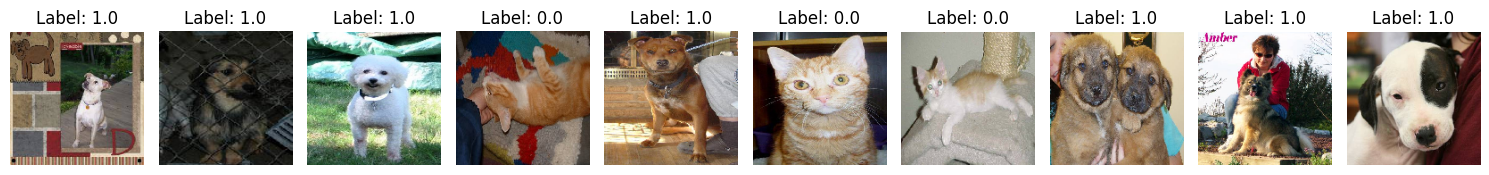

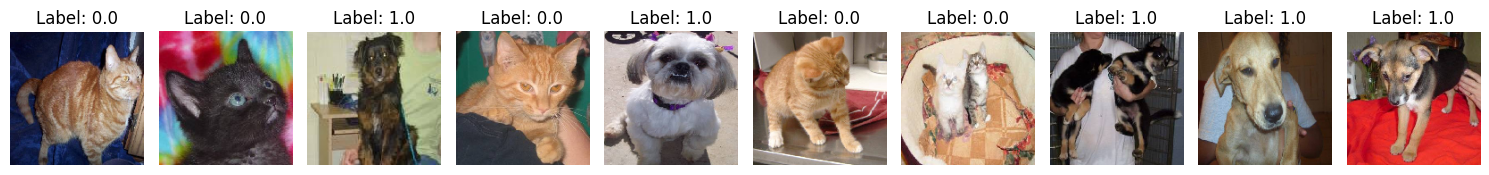

In [24]:
import matplotlib.pyplot as plt

# Obtener un lote de imágenes y etiquetas de entrenamiento
images_train, labels_train = train.next()

# Obtener un lote de imágenes y etiquetas de prueba
images_test, labels_test = test.next()

# Función para mostrar imágenes con etiquetas
def show_images(images, labels, num_images_to_show):
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))
    for i in range(num_images_to_show):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Mostrar 10 imágenes de entrenamiento con sus etiquetas
show_images(images_train, labels_train, 10)

# Mostrar 10 imágenes de prueba con sus etiquetas
show_images(images_test, labels_test, 10)



#Definición de la función create_model con integración de Optuna y MLflow con Convoluciones

In [25]:
def create_model(trial):
    model = models.Sequential()

    # Número de capas convolucionales sugerido por Optuna
    n_conv_layers = trial.suggest_int("n_conv_layers", 1, 3)

    # Añadir capas convolucionales al modelo
    for i in range(n_conv_layers):
        filters = trial.suggest_int(f"conv_filters_{i}", 16, 128, log=True)
        kernel_size = trial.suggest_int(f"kernel_size_{i}", 3, 5)
        conv_stride = trial.suggest_int(f"conv_stride_{i}", 1, 3)

        # Añadir la capa convolucional
        model.add(layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=conv_stride,
                                 activation='relu', input_shape=(150, 150, 3)))

    # Añadir capa de max pooling después de cada capa convolucional
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Aplanar los datos para la capa completamente conectada
    model.add(layers.Flatten())

    # Número de capas densas sugerido por Optuna
    n_dense_layers = trial.suggest_int("n_dense_layers", 1, 3)

    # Añadir capas densas al modelo
    for i in range(n_dense_layers):
        units = trial.suggest_int(f"dense_units_{i}", 32, 128)
        model.add(layers.Dense(units, activation='relu'))

    # Capa de salida con una sola unidad y activación sigmoid
    model.add(layers.Dense(1, activation='sigmoid'))

    # Optuna sugiere: Valor de learning rate
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)

    # Optuna sugiere: Optimizer
    optimizer_options = ["adam", "rmsprop"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)

    if optimizer_selected == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_selected == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)


    mlflow.tensorflow.autolog()

    # Especificar la ruta donde quieres guardar el modelo
    filepath = "best_model.hdf5"

    # Inicializar el callback ModelCheckpoint
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    earlystop = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10, verbose=1)

    trial_number = trial.number

    # Construir el nombre del experimento con el número de intento actual
    experiment_name = f"Experiment_{trial_number}"

    # Configurar MLflow con el nombre del experimento construido
    mlflow.set_experiment(experiment_name=experiment_name)

    mlflow.start_run(nested='TRUE')

    # Compilamos el modelo
    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",  # Cambiamos la función de pérdida a 'binary_crossentropy'
                  metrics=["accuracy"])

    return model

#Función objetivo para la optimización de hiperparámetros utilizando Optuna"

In [44]:
def objective(trial):
    modelo = create_model(trial)
    modelo.fit(x_train, y_train, epochs=10, batch_size=50, verbose=0)
    loss, accuracy = modelo.evaluate(x_test, y_test, verbose=0)
    return loss

#Optimización de hiperparámetros utilizando Optuna

In [45]:
study = optuna.create_study(direction = "minimize")

study.optimize(objective, n_trials = 30)

[I 2024-03-19 05:07:12,582] A new study created in memory with name: no-name-2333c48d-0320-4b3f-8d3e-c21f07869020
2024/03/19 05:07:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:07:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:07:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:07:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config 

1/1 [==============================] - 0s 78ms/step


[I 2024-03-19 05:07:46,174] Trial 0 finished with value: 0.6629853844642639 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 117, 'kernel_size_0': 3, 'conv_stride_0': 3, 'n_dense_layers': 1, 'dense_units_0': 79, 'lr': 4.268386612510923e-05, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:07:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:07:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:08:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored me

1/1 [==============================] - 0s 185ms/step


[I 2024-03-19 05:08:53,676] Trial 1 finished with value: 0.6774441599845886 and parameters: {'n_conv_layers': 2, 'conv_filters_0': 106, 'kernel_size_0': 3, 'conv_stride_0': 1, 'conv_filters_1': 37, 'kernel_size_1': 3, 'conv_stride_1': 2, 'n_dense_layers': 2, 'dense_units_0': 108, 'dense_units_1': 114, 'lr': 0.0003141498361376984, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:08:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:08:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:09:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, bec

1/1 [==============================] - 0s 113ms/step


[I 2024-03-19 05:09:29,898] Trial 2 finished with value: 0.7199674248695374 and parameters: {'n_conv_layers': 2, 'conv_filters_0': 21, 'kernel_size_0': 4, 'conv_stride_0': 1, 'conv_filters_1': 20, 'kernel_size_1': 4, 'conv_stride_1': 3, 'n_dense_layers': 3, 'dense_units_0': 68, 'dense_units_1': 50, 'dense_units_2': 42, 'lr': 0.0002942855987597872, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:09:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:09:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:09:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint loggi

1/1 [==============================] - 0s 112ms/step


[I 2024-03-19 05:10:16,603] Trial 3 finished with value: 0.6689702868461609 and parameters: {'n_conv_layers': 2, 'conv_filters_0': 40, 'kernel_size_0': 5, 'conv_stride_0': 1, 'conv_filters_1': 47, 'kernel_size_1': 3, 'conv_stride_1': 3, 'n_dense_layers': 1, 'dense_units_0': 109, 'lr': 0.0002897718064367927, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:10:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:10:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:10:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best

1/1 [==============================] - 0s 153ms/step


[I 2024-03-19 05:11:05,720] Trial 4 finished with value: 0.6947175860404968 and parameters: {'n_conv_layers': 3, 'conv_filters_0': 57, 'kernel_size_0': 5, 'conv_stride_0': 1, 'conv_filters_1': 104, 'kernel_size_1': 3, 'conv_stride_1': 3, 'conv_filters_2': 20, 'kernel_size_2': 5, 'conv_stride_2': 3, 'n_dense_layers': 2, 'dense_units_0': 51, 'dense_units_1': 65, 'lr': 1.4143074073727315e-05, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:11:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:11:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:11:10 WARNING mlflow.

1/1 [==============================] - 0s 123ms/step


[I 2024-03-19 05:11:32,085] Trial 5 finished with value: 0.6838693022727966 and parameters: {'n_conv_layers': 2, 'conv_filters_0': 72, 'kernel_size_0': 4, 'conv_stride_0': 3, 'conv_filters_1': 27, 'kernel_size_1': 4, 'conv_stride_1': 2, 'n_dense_layers': 1, 'dense_units_0': 76, 'lr': 6.32687989655748e-05, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:11:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:11:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:11:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_bes

1/1 [==============================] - 0s 152ms/step


[I 2024-03-19 05:13:15,688] Trial 6 finished with value: 0.6731404066085815 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 88, 'kernel_size_0': 4, 'conv_stride_0': 1, 'n_dense_layers': 3, 'dense_units_0': 80, 'dense_units_1': 86, 'dense_units_2': 51, 'lr': 1.4472228082657678e-05, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:13:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:13:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:13:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is Tru

1/1 [==============================] - 0s 300ms/step


[I 2024-03-19 05:14:12,323] Trial 7 finished with value: 0.6894479393959045 and parameters: {'n_conv_layers': 3, 'conv_filters_0': 84, 'kernel_size_0': 5, 'conv_stride_0': 1, 'conv_filters_1': 25, 'kernel_size_1': 3, 'conv_stride_1': 2, 'conv_filters_2': 36, 'kernel_size_2': 4, 'conv_stride_2': 2, 'n_dense_layers': 1, 'dense_units_0': 35, 'lr': 0.000311221011670294, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:14:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:14:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:14:17 WARNING mlflow.utils.checkpoint_util

1/1 [==============================] - 0s 86ms/step


[I 2024-03-19 05:14:46,857] Trial 8 finished with value: 0.6888218522071838 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 92, 'kernel_size_0': 5, 'conv_stride_0': 3, 'n_dense_layers': 2, 'dense_units_0': 105, 'dense_units_1': 65, 'lr': 0.000425525428450951, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:14:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:14:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:14:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to comp

1/1 [==============================] - 0s 105ms/step


[I 2024-03-19 05:15:19,781] Trial 9 finished with value: 0.6777734160423279 and parameters: {'n_conv_layers': 3, 'conv_filters_0': 41, 'kernel_size_0': 3, 'conv_stride_0': 2, 'conv_filters_1': 31, 'kernel_size_1': 5, 'conv_stride_1': 3, 'conv_filters_2': 53, 'kernel_size_2': 3, 'conv_stride_2': 2, 'n_dense_layers': 1, 'dense_units_0': 110, 'lr': 0.0006872277979133573, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:15:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:15:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:15:23 WARNING mlflow.utils.checkpoint_ut

1/1 [==============================] - 0s 78ms/step


[I 2024-03-19 05:15:48,325] Trial 10 finished with value: 0.690775990486145 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 19, 'kernel_size_0': 3, 'conv_stride_0': 2, 'n_dense_layers': 1, 'dense_units_0': 125, 'lr': 5.2298590224960296e-05, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:15:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:15:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:15:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored m

1/1 [==============================] - 0s 86ms/step


[I 2024-03-19 05:16:13,320] Trial 11 finished with value: 0.6709083318710327 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 35, 'kernel_size_0': 4, 'conv_stride_0': 3, 'n_dense_layers': 1, 'dense_units_0': 94, 'lr': 0.0001146291477069907, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:16:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:16:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:16:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored me

1/1 [==============================] - 0s 137ms/step


[I 2024-03-19 05:17:08,166] Trial 12 finished with value: 0.6828156113624573 and parameters: {'n_conv_layers': 2, 'conv_filters_0': 30, 'kernel_size_0': 3, 'conv_stride_0': 2, 'conv_filters_1': 68, 'kernel_size_1': 5, 'conv_stride_1': 1, 'n_dense_layers': 1, 'dense_units_0': 60, 'lr': 0.00012106075504097244, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:17:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:17:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:17:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_bes

1/1 [==============================] - 0s 99ms/step


[I 2024-03-19 05:17:36,154] Trial 13 finished with value: 0.6730592250823975 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 55, 'kernel_size_0': 5, 'conv_stride_0': 3, 'n_dense_layers': 2, 'dense_units_0': 93, 'dense_units_1': 33, 'lr': 4.2807009692021896e-05, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:17:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:17:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:17:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to co

1/1 [==============================] - 0s 159ms/step


[I 2024-03-19 05:18:47,796] Trial 14 finished with value: 0.6645011901855469 and parameters: {'n_conv_layers': 2, 'conv_filters_0': 126, 'kernel_size_0': 4, 'conv_stride_0': 2, 'conv_filters_1': 51, 'kernel_size_1': 3, 'conv_stride_1': 1, 'n_dense_layers': 1, 'dense_units_0': 124, 'lr': 3.453769286304557e-05, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:18:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:18:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:18:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_be

1/1 [==============================] - 0s 96ms/step


[I 2024-03-19 05:19:47,427] Trial 15 finished with value: 0.671800971031189 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 125, 'kernel_size_0': 3, 'conv_stride_0': 2, 'n_dense_layers': 2, 'dense_units_0': 90, 'dense_units_1': 125, 'lr': 2.5476882236297836e-05, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:20:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:20:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:20:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to c

1/1 [==============================] - 0s 352ms/step


[I 2024-03-19 05:22:32,402] Trial 16 finished with value: 0.6822169423103333 and parameters: {'n_conv_layers': 3, 'conv_filters_0': 128, 'kernel_size_0': 4, 'conv_stride_0': 2, 'conv_filters_1': 57, 'kernel_size_1': 4, 'conv_stride_1': 1, 'conv_filters_2': 110, 'kernel_size_2': 5, 'conv_stride_2': 1, 'n_dense_layers': 1, 'dense_units_0': 126, 'lr': 2.7360477767665537e-05, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:22:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:22:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:22:40 WARNING mlflow.utils.checkpoint_u

1/1 [==============================] - 0s 121ms/step


[I 2024-03-19 05:23:18,450] Trial 17 finished with value: 0.6896871328353882 and parameters: {'n_conv_layers': 2, 'conv_filters_0': 66, 'kernel_size_0': 3, 'conv_stride_0': 3, 'conv_filters_1': 103, 'kernel_size_1': 3, 'conv_stride_1': 1, 'n_dense_layers': 3, 'dense_units_0': 51, 'dense_units_1': 97, 'dense_units_2': 128, 'lr': 2.5349524637375424e-05, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6629853844642639.
2024/03/19 05:23:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:23:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:23:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logg

1/1 [==============================] - 1s 1s/step


[I 2024-03-19 05:25:16,973] Trial 18 finished with value: 0.6607431173324585 and parameters: {'n_conv_layers': 2, 'conv_filters_0': 107, 'kernel_size_0': 4, 'conv_stride_0': 2, 'conv_filters_1': 76, 'kernel_size_1': 4, 'conv_stride_1': 1, 'n_dense_layers': 1, 'dense_units_0': 80, 'lr': 6.428408993369081e-05, 'optimizer': 'adam'}. Best is trial 18 with value: 0.6607431173324585.
2024/03/19 05:25:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:25:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:25:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_be

1/1 [==============================] - 0s 78ms/step


[I 2024-03-19 05:25:40,738] Trial 19 finished with value: 0.6703567504882812 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 25, 'kernel_size_0': 3, 'conv_stride_0': 3, 'n_dense_layers': 2, 'dense_units_0': 82, 'dense_units_1': 103, 'lr': 8.185650797073347e-05, 'optimizer': 'adam'}. Best is trial 18 with value: 0.6607431173324585.
2024/03/19 05:25:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:25:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:25:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to c

1/1 [==============================] - 0s 192ms/step


[I 2024-03-19 05:27:35,203] Trial 20 finished with value: 0.6686660051345825 and parameters: {'n_conv_layers': 3, 'conv_filters_0': 16, 'kernel_size_0': 4, 'conv_stride_0': 2, 'conv_filters_1': 73, 'kernel_size_1': 5, 'conv_stride_1': 1, 'conv_filters_2': 114, 'kernel_size_2': 3, 'conv_stride_2': 1, 'n_dense_layers': 1, 'dense_units_0': 66, 'lr': 0.00015690721154452367, 'optimizer': 'adam'}. Best is trial 18 with value: 0.6607431173324585.
2024/03/19 05:27:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:27:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:28:02 WARNING mlflow.utils.checkpoint_ut

1/1 [==============================] - 0s 270ms/step


[I 2024-03-19 05:29:37,878] Trial 21 finished with value: 0.6904710531234741 and parameters: {'n_conv_layers': 2, 'conv_filters_0': 106, 'kernel_size_0': 4, 'conv_stride_0': 2, 'conv_filters_1': 128, 'kernel_size_1': 4, 'conv_stride_1': 1, 'n_dense_layers': 1, 'dense_units_0': 86, 'lr': 3.454553753522203e-05, 'optimizer': 'adam'}. Best is trial 18 with value: 0.6607431173324585.
2024/03/19 05:29:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:29:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:29:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_b

1/1 [==============================] - 0s 304ms/step


[I 2024-03-19 05:30:50,200] Trial 22 finished with value: 0.6661706566810608 and parameters: {'n_conv_layers': 2, 'conv_filters_0': 105, 'kernel_size_0': 4, 'conv_stride_0': 2, 'conv_filters_1': 49, 'kernel_size_1': 4, 'conv_stride_1': 1, 'n_dense_layers': 1, 'dense_units_0': 99, 'lr': 6.804821527337281e-05, 'optimizer': 'adam'}. Best is trial 18 with value: 0.6607431173324585.
2024/03/19 05:30:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:30:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:30:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_be

1/1 [==============================] - 0s 102ms/step


[I 2024-03-19 05:31:21,839] Trial 23 finished with value: 0.6867172122001648 and parameters: {'n_conv_layers': 2, 'conv_filters_0': 72, 'kernel_size_0': 4, 'conv_stride_0': 2, 'conv_filters_1': 78, 'kernel_size_1': 3, 'conv_stride_1': 2, 'n_dense_layers': 1, 'dense_units_0': 71, 'lr': 1.9550670506676475e-05, 'optimizer': 'adam'}. Best is trial 18 with value: 0.6607431173324585.
2024/03/19 05:31:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:31:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:31:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_be

1/1 [==============================] - 0s 144ms/step


[I 2024-03-19 05:32:02,131] Trial 24 finished with value: 0.6622459292411804 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 123, 'kernel_size_0': 3, 'conv_stride_0': 2, 'n_dense_layers': 1, 'dense_units_0': 56, 'lr': 3.921695050944265e-05, 'optimizer': 'adam'}. Best is trial 18 with value: 0.6607431173324585.
2024/03/19 05:32:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:32:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:32:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored 

1/1 [==============================] - 0s 79ms/step


[I 2024-03-19 05:32:32,095] Trial 25 finished with value: 0.6779409050941467 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 99, 'kernel_size_0': 3, 'conv_stride_0': 3, 'n_dense_layers': 2, 'dense_units_0': 38, 'dense_units_1': 32, 'lr': 0.00016797044231723157, 'optimizer': 'adam'}. Best is trial 18 with value: 0.6607431173324585.
2024/03/19 05:32:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:32:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:32:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to c

1/1 [==============================] - 0s 82ms/step


[I 2024-03-19 05:33:01,087] Trial 26 finished with value: 0.6687370538711548 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 51, 'kernel_size_0': 3, 'conv_stride_0': 2, 'n_dense_layers': 1, 'dense_units_0': 57, 'lr': 4.953308335093684e-05, 'optimizer': 'rmsprop'}. Best is trial 18 with value: 0.6607431173324585.
2024/03/19 05:33:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:33:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:33:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitore

1/1 [==============================] - 0s 86ms/step


[I 2024-03-19 05:33:35,203] Trial 27 finished with value: 0.6757420897483826 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 80, 'kernel_size_0': 3, 'conv_stride_0': 2, 'n_dense_layers': 1, 'dense_units_0': 46, 'lr': 9.023889597179953e-05, 'optimizer': 'adam'}. Best is trial 18 with value: 0.6607431173324585.
2024/03/19 05:33:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:33:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:33:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored m

1/1 [==============================] - 0s 89ms/step


[I 2024-03-19 05:34:06,616] Trial 28 finished with value: 0.687446117401123 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 110, 'kernel_size_0': 3, 'conv_stride_0': 3, 'n_dense_layers': 2, 'dense_units_0': 74, 'dense_units_1': 73, 'lr': 1.0982647263420024e-05, 'optimizer': 'adam'}. Best is trial 18 with value: 0.6607431173324585.
2024/03/19 05:34:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:34:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/03/19 05:34:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to c

1/1 [==============================] - 0s 80ms/step


[I 2024-03-19 05:34:32,172] Trial 29 finished with value: 0.6738956570625305 and parameters: {'n_conv_layers': 1, 'conv_filters_0': 63, 'kernel_size_0': 3, 'conv_stride_0': 3, 'n_dense_layers': 2, 'dense_units_0': 64, 'dense_units_1': 50, 'lr': 3.7022264836318944e-05, 'optimizer': 'rmsprop'}. Best is trial 18 with value: 0.6607431173324585.


#Obtención de los mejores hiperparámetros de la optimización de Optuna

In [72]:
print("Número de pruebas terminadas:", len(study.trials))

best_trial = study.best_trial

print("Mejor intento:", best_trial.number)
print("Valor:", best_trial.value)
print("Hiperparámetros:", best_trial.params)


Número de pruebas terminadas: 30
Mejor intento: 18
Valor: 0.6607431173324585
Hiperparámetros: {'n_conv_layers': 2, 'conv_filters_0': 107, 'kernel_size_0': 4, 'conv_stride_0': 2, 'conv_filters_1': 76, 'kernel_size_1': 4, 'conv_stride_1': 1, 'n_dense_layers': 1, 'dense_units_0': 80, 'lr': 6.428408993369081e-05, 'optimizer': 'adam'}


In [55]:
type(best_trial.params)

dict

In [53]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

In [54]:
from optuna.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study)

[W 2024-03-19 05:39:59,324] Your study has only completed trials with missing parameters.


In [48]:
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [49]:
from optuna.visualization import plot_rank
plot_rank(study)

<ipython-input-49-23955ce77b8a>:2: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



#RED NEURONAL USANDO LOS HIPERPARAMETROS OBTENIDOS.

Accedemos a un nuevo repositorio.

In [111]:
REPO_NAME= "Red_Neuronal_Gatos_y_perros"
REPO_OWNER= "chichastark14"
USER_NAME = "chichastark14"

In [112]:
import mlflow
import os
from getpass import getpass

os.environ['MLFLOW_TRACKING_USERNAME'] = USER_NAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token or password: ')

mlflow.set_tracking_uri(f'https://dagshub.com/{REPO_OWNER}/{REPO_NAME}.mlflow')

Enter your DAGsHub access token or password: ··········


In [113]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ih, iw = 150, 150  # Tamaño de la imagen
input_shape = (ih, iw, 3)  # Forma de la imagen: alto, ancho y número de canales

train_dir = 'train'  # Directorio de entrenamiento
test_dir = 'test'  # Directorio de prueba

batch_size = 50  # Tamaño del lote para cada entrenamiento
num_train = 20000  # Número de imágenes en entrenamiento
num_test = 5000  # Número de imágenes en prueba

epoch_steps = num_train // batch_size
test_steps = num_test // batch_size

gentrain = ImageDataGenerator(rescale=1. / 255.)  # No especificamos color_mode aquí
train = gentrain.flow_from_directory(train_dir,
                                     batch_size=batch_size,
                                     target_size=(iw, ih),
                                     class_mode='binary',
                                     color_mode='rgb')  # Especificamos color_mode='rgb' aquí

gentest = ImageDataGenerator(rescale=1. / 255.)  # No especificamos color_mode aquí
test = gentest.flow_from_directory(test_dir,
                                   batch_size=batch_size,
                                   target_size=(iw, ih),
                                   class_mode='binary',
                                   color_mode='rgb')  # Especificamos color_mode='rgb' aquí

# Obtener x_train y y_train del objeto train
x_train, y_train = train.next()

# Obtener x_test y y_test del objeto test
x_test, y_test = test.next()

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


#MEJOR EXPERIMENTO SEGÚN DAGSHUB

In [114]:
trial_29 = study.trials[29]
hyperparameters_29 = trial_29.params
print("Hiperparámetros del intento 29:", hyperparameters_29)


Hiperparámetros del intento 29: {'n_conv_layers': 1, 'conv_filters_0': 63, 'kernel_size_0': 3, 'conv_stride_0': 3, 'n_dense_layers': 2, 'dense_units_0': 64, 'dense_units_1': 50, 'lr': 3.7022264836318944e-05, 'optimizer': 'rmsprop'}


In [115]:
def create_model():
    model = models.Sequential()

    # Capa convolucional
    model.add(layers.Conv2D(filters=63, kernel_size=3, strides=3, activation='relu', input_shape=(150, 150, 3)))

    # Capa de MaxPooling
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Aplanar los datos para la capa completamente conectada
    model.add(layers.Flatten())

    # Capas densas
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))

    # Capa de salida
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Crear el modelo
model = create_model()

# Mostrar el resumen del modelo
model.summary()

Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_270 (Conv2D)         (None, 50, 50, 63)        1764      
                                                                 
 max_pooling2d_139 (MaxPool  (None, 25, 25, 63)        0         
 ing2D)                                                          
                                                                 
 flatten_139 (Flatten)       (None, 39375)             0         
                                                                 
 dense_399 (Dense)           (None, 64)                2520064   
                                                                 
 dense_400 (Dense)           (None, 50)                3250      
                                                                 
 dense_401 (Dense)           (None, 1)                 51        
                                                    

In [116]:
# Definir el learning rate
learning_rate = 3.7022264836318944e-05

# Crear el optimizador Adam con el learning rate especificado
optimizer = RMSprop(learning_rate=learning_rate)

mlflow.tensorflow.autolog()

# Especificar la ruta donde quieres guardar el modelo
filepath = "best_model.hdf5"

# Inicializar el callback ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

earlystop = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10, verbose=1)

mlflow.set_experiment(experiment_name="Hiperparametros_Dagshub")


mlflow.start_run(nested='TRUE')


# Compilar el modelo utilizando el optimizador configurado
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(x_train, y_train, epochs=10, batch_size=50, validation_data=(x_test, y_test))

mlflow.end_run()


2024/03/19 07:04:49 INFO mlflow.tracking.fluent: Experiment with name 'Hiperparametros_Dagshub' does not exist. Creating a new experiment.


Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.4800

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1/1 [==============================] - 4s 4s/step - loss: 0.6953 - accuracy: 0.4800 - val_loss: 0.6923 - val_accuracy: 0.5400
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.6813 - accuracy: 0.5600 - val_loss: 0.6877 - val_accuracy: 0.5800
Epoch 3/10
1/1 [==============================] - 0s 252ms/step - loss: 0.6655 - accuracy: 0.7800 - val_loss: 0.6886 - val_accuracy: 0.5600
Epoch 4/10
1/1 [==============================] - 0s 237ms/step - loss: 0.6550 - accuracy: 0.6200 - val_loss: 0.6906 - val_accuracy: 0.4800
Epoch 5/10
1/1 [==============================] - 0s 243ms/step - loss: 0.6590 - accuracy: 0.6000 - val_loss: 0.6944 - val_accuracy: 0.5200
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.6475 - accuracy: 0.5800 - val_loss: 0.6872 - val_accuracy: 0.4600
Epoch 7/10
1/1 [==============================] - 0s 274ms/step - loss: 0.6372 - accuracy: 0.7200 - val_loss: 0.6906 - val_accuracy: 0.5800
Epoch 8/10
1/1 [========================

In [117]:
# Evaluación del modelo en los datos de prueba
test_loss, test_accuracy = model.evaluate(x_test, y_test)


2/2 [==============================] - 0s 24ms/step - loss: 0.6880 - accuracy: 0.5400


#MEJOR EXPERIMENTO SEGÚN OPTUNA Y PYTHON


In [118]:
best_trial.params

{'n_conv_layers': 2,
 'conv_filters_0': 107,
 'kernel_size_0': 4,
 'conv_stride_0': 2,
 'conv_filters_1': 76,
 'kernel_size_1': 4,
 'conv_stride_1': 1,
 'n_dense_layers': 1,
 'dense_units_0': 80,
 'lr': 6.428408993369081e-05,
 'optimizer': 'adam'}

In [119]:
def create_model():
    model = models.Sequential()

    # Capa convolucional
    model.add(layers.Conv2D(filters=107, kernel_size=4, strides=2, activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.Conv2D(filters=76, kernel_size=4, strides=1, activation='relu', input_shape=(150, 150, 3)))

    # Capa de MaxPooling
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Aplanar los datos para la capa completamente conectada
    model.add(layers.Flatten())

    # Capas densas
    model.add(layers.Dense(80, activation='relu'))

    # Capa de salida
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Crear el modelo
model = create_model()

# Mostrar el resumen del modelo
model.summary()

Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_271 (Conv2D)         (None, 74, 74, 107)       5243      
                                                                 
 conv2d_272 (Conv2D)         (None, 71, 71, 76)        130188    
                                                                 
 max_pooling2d_140 (MaxPool  (None, 35, 35, 76)        0         
 ing2D)                                                          
                                                                 
 flatten_140 (Flatten)       (None, 93100)             0         
                                                                 
 dense_402 (Dense)           (None, 80)                7448080   
                                                                 
 dense_403 (Dense)           (None, 1)                 81        
                                                    

In [120]:
# Definir el learning rate
learning_rate = 6.428408993369081e-05

# Crear el optimizador Adam con el learning rate especificado
optimizer = Adam(learning_rate=learning_rate)

mlflow.tensorflow.autolog()

# Especificar la ruta donde quieres guardar el modelo
filepath = "best_model.hdf5"

# Inicializar el callback ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

earlystop = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10, verbose=1)

mlflow.set_experiment(experiment_name="Hiperparametros_optuna_python")


mlflow.start_run(nested='TRUE')


# Compilar el modelo utilizando el optimizador configurado
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(x_train, y_train, epochs=10, batch_size=50, validation_data=(x_test, y_test))

mlflow.end_run()



2024/03/19 07:05:40 INFO mlflow.tracking.fluent: Experiment with name 'Hiperparametros_optuna_python' does not exist. Creating a new experiment.


Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.6000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1/1 [==============================] - 20s 20s/step - loss: 0.6853 - accuracy: 0.6000 - val_loss: 0.7592 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 18s 18s/step - loss: 0.6832 - accuracy: 0.5400 - val_loss: 0.7007 - val_accuracy: 0.4800
Epoch 3/10
1/1 [==============================] - 16s 16s/step - loss: 0.6502 - accuracy: 0.6600 - val_loss: 0.6994 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 7s 7s/step - loss: 0.6187 - accuracy: 0.7400 - val_loss: 0.7037 - val_accuracy: 0.5200
Epoch 5/10
1/1 [==============================] - 8s 8s/step - loss: 0.5758 - accuracy: 0.7400 - val_loss: 0.7289 - val_accuracy: 0.5800
Epoch 6/10
1/1 [==============================] - 17s 17s/step - loss: 0.5515 - accuracy: 0.7000 - val_loss: 0.7284 - val_accuracy: 0.5200
Epoch 7/10
1/1 [==============================] - 17s 17s/step - loss: 0.5152 - accuracy: 0.7600 - val_loss: 0.7263 - val_accuracy: 0.5000
Epoch 8/10
1/1 [==========================

In [121]:
# Evaluación del modelo en los datos de prueba
test_loss, test_accuracy = model.evaluate(x_test, y_test)


2/2 [==============================] - 3s 986ms/step - loss: 0.7996 - accuracy: 0.5200


#Cambio de optimizador

In [122]:
# Definir el learning rate
learning_rate = 6.428408993369081e-05

# Crear el optimizador Adam con el learning rate especificado
optimizer = RMSprop(learning_rate=learning_rate)

mlflow.tensorflow.autolog()

# Especificar la ruta donde quieres guardar el modelo
filepath = "best_model.hdf5"

# Inicializar el callback ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

earlystop = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10, verbose=1)

mlflow.set_experiment(experiment_name="Hiperparametros_optuna_python_RMSprop")


mlflow.start_run(nested='TRUE')


# Compilar el modelo utilizando el optimizador configurado
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(x_train, y_train, epochs=10, batch_size=50, validation_data=(x_test, y_test))

mlflow.end_run()

2024/03/19 07:08:42 INFO mlflow.tracking.fluent: Experiment with name 'Hiperparametros_optuna_python_RMSprop' does not exist. Creating a new experiment.


Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 0.4182 - accuracy: 0.8400

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1/1 [==============================] - 15s 15s/step - loss: 0.4182 - accuracy: 0.8400 - val_loss: 2.3858 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 14s 14s/step - loss: 2.0492 - accuracy: 0.4800 - val_loss: 1.5858 - val_accuracy: 0.5200
Epoch 3/10
1/1 [==============================] - 14s 14s/step - loss: 1.0437 - accuracy: 0.5400 - val_loss: 0.8052 - val_accuracy: 0.5200
Epoch 4/10
1/1 [==============================] - 9s 9s/step - loss: 0.5147 - accuracy: 0.7200 - val_loss: 0.8058 - val_accuracy: 0.6000
Epoch 5/10
1/1 [==============================] - 14s 14s/step - loss: 0.4429 - accuracy: 0.7600 - val_loss: 0.7588 - val_accuracy: 0.5200
Epoch 6/10
1/1 [==============================] - 8s 8s/step - loss: 0.4266 - accuracy: 0.8200 - val_loss: 0.8095 - val_accuracy: 0.6000
Epoch 7/10
1/1 [==============================] - 14s 14s/step - loss: 0.4158 - accuracy: 0.8000 - val_loss: 0.7721 - val_accuracy: 0.5200
Epoch 8/10
1/1 [==========================

In [123]:
# Evaluación del modelo en los datos de prueba
test_loss, test_accuracy = model.evaluate(x_test, y_test)


2/2 [==============================] - 2s 572ms/step - loss: 0.9122 - accuracy: 0.5600


#Este último intento sería la mejor opción.